In [105]:
from functions import *

from scipy.integrate import solve_ivp
from scipy.optimize import minimize

In [106]:
n = 6
T = 0.01

In [107]:
def get_proposal_mat_ra(m, ramp_up_schedule, t_max):
    H_ising = np.diag(m.E_rescaled)
    H_mixer = H_mixer_list[m.n-1]
    d = int(2**m.n)

    def s(t): return t/t_max

    def f(s, ramp_up_schedule):
        ramp_down_schedule = ramp_up_schedule[::-1]
        schedule = np.concatenate([ramp_up_schedule, ramp_down_schedule])
        n_points = len(schedule)
        times = np.linspace(0, 1, n_points)
        time_step = 1 / (n_points - 1)

        # Check if x is outside the range of the points
        if s < 0 or s > 1:
            raise ValueError("t is out of the bounds")

        # Find the correct interval for x
        for i in range(n_points - 1):
            if times[i] <= s <= times[i+1]:
                # Extract points (x0, y0) and (x1, y1)
                y0 = schedule[i]
                s0 = times[i]
                y1 = schedule[i + 1]
                
                # Linear interpolation formula
                return y0 + (y1 - y0) * (s - s0) / time_step

    def hamiltonian(t): return (1-f(s(t), ramp_up_schedule))*H_ising + f(s(t), ramp_up_schedule)*H_mixer

    def tdse_U(t, U): 
        return -1j*(hamiltonian(t)@U.reshape(d,d)).flatten()
    
    U0 = np.eye(d, dtype=complex).flatten()

    sol = solve_ivp(tdse_U, 
                    [0, t_max], 
                    y0=U0, 
                    rtol=1e-10, 
                    method='RK23')
    
    U_t = sol.y.T[-1].reshape(d,d)
    return np.abs(U_t)**2

In [108]:
def loss(ramp_up_schedule, t_max = 10):
    delta_avg = 0
    n_random_models = 10
    for seed in range(n_random_models):
        m = RandomIsingModel(n=n, seed=seed)
        proposal_mat_ra = get_proposal_mat_ra(m, ramp_up_schedule, t_max)
        P = get_transition_matrix(m, T, proposal_mat_ra)
        delta_avg += get_delta(P) / n_random_models
    return -delta_avg

In [109]:
f_max = 0.5
t_max = 10
ramp_up_schedule_init = np.concatenate([np.linspace(0, f_max, 3), np.ones(3)*f_max])

In [110]:
res = minimize(loss, 
               ramp_up_schedule_init, 
               method='Nelder-Mead',
               options={"disp":True, "maxiter":200})   

C:\Users\ivash\AppData\Local\Temp\ipykernel_17088\2318758607.py:1: RuntimeWarning: Maximum number of iterations has been exceeded.
  res = minimize(loss,


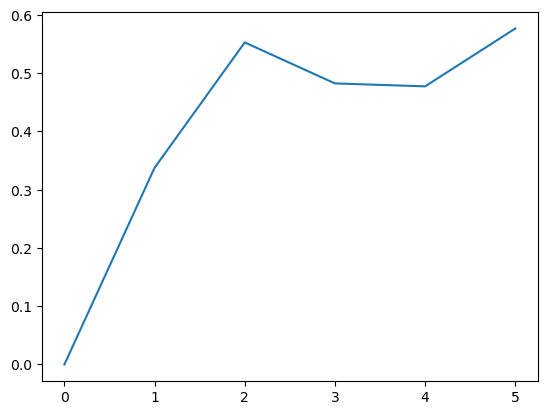

In [111]:
plt.plot(res.x)

In [112]:
res.x

array([-2.21779877e-04,  3.37631126e-01,  5.52887994e-01,  4.82486234e-01,
        4.77439438e-01,  5.76853514e-01])

In [113]:
loss(res.x)

-0.0939906328808895